In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import utils as ut

DATA_PATH = '../datav2/esp/'

%load_ext autoreload
%autoreload 2

In [2]:
df = ut.load_data(DATA_PATH,'train',nclasses=5).loc[:,['review_content','review_rate']]
df.head(5)

Dataset cargado para 5 clases (muy malo=0, malo=2, medio=3, bueno=4 muy bueno=1)
Num samples per category:
1    92477
2    92449
3    92487
4    92501
5    92454
Name: review_rate, dtype: int64


,review_content,review_rate
0,"Esta de muy baja calidad, no fue lo esperado.",2
1,"Reconozco que fue muy económico, pero su durab...",2
2,Muy bien muy bien muy bien muy bien muy bien m...,5
3,No me fue útil para mí. Diseño muy bueno.,2
4,No fue lo estipulado. Solo eso voy aclarar.,1


## Inspeccionamos los caracteres presentes en el texto

In [3]:
from collections import Counter

characters_counts = Counter(''.join(df['review_content'].tolist()))
counts = np.array(list(characters_counts.values()))
idx_sorted = np.argsort(counts)[::-1]
counts = counts[idx_sorted]
chars = np.array(list(characters_counts.keys()))[idx_sorted]

<IPython.core.display.Javascript object>


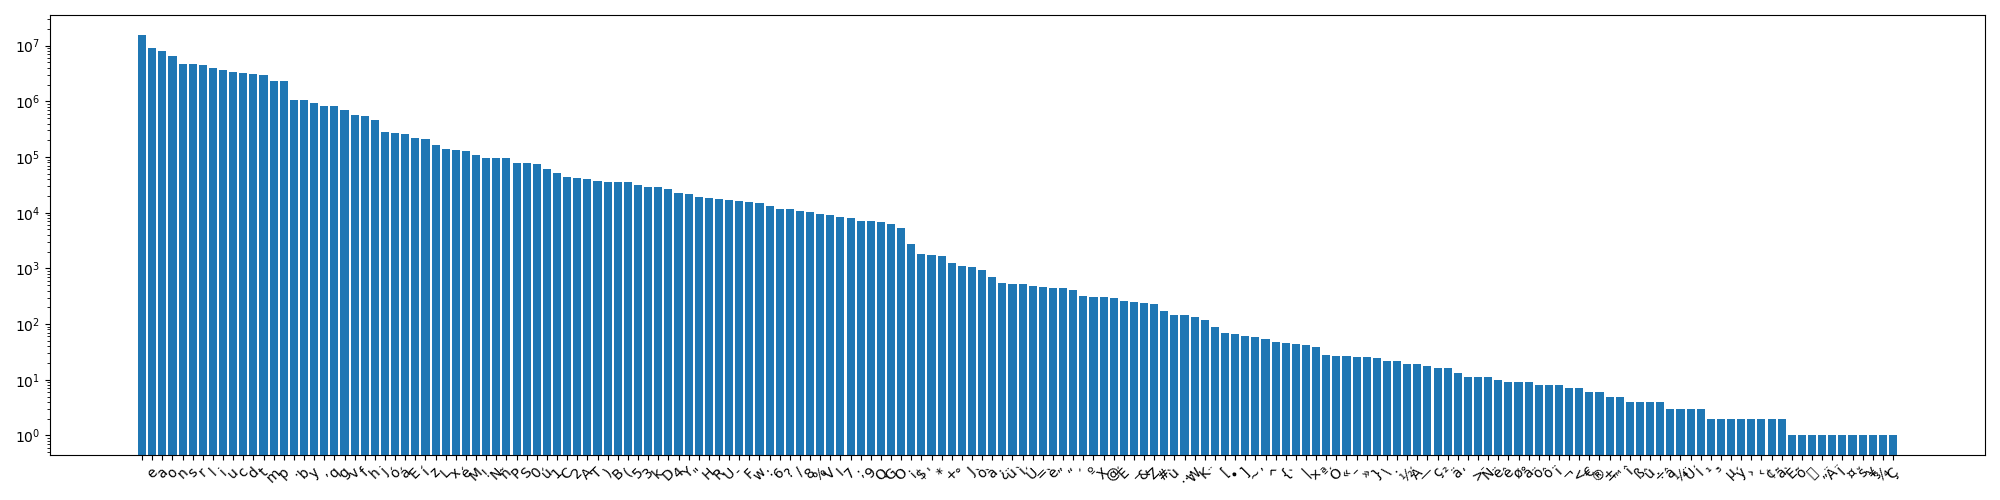

/home/lestien/anaconda3/envs/nlpenv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)


In [4]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ticks = np.arange(len(counts))
ax.bar(ticks, counts)
ax.set_xticks(ticks)
ax.set_xticklabels(chars,fontsize='medium',rotation=45)
ax.set_yscale('log')
fig.tight_layout()

In [5]:
print(characters_counts)

Counter({' ': 15529258, 'e': 9192223, 'a': 8135899, 'o': 6560746, 'n': 4681413, 's': 4592094, 'r': 4414618, 'l': 3970686, 'i': 3676852, 'u': 3309802, 'c': 3207915, 'd': 3048383, 't': 2963915, 'm': 2300953, 'p': 2287417, '.': 1068769, 'b': 1053220, 'y': 931003, ',': 815459, 'q': 808659, 'g': 686218, 'v': 573870, 'f': 540924, 'h': 465089, 'j': 285811, 'ó': 275622, 'á': 258756, 'E': 219522, 'í': 209602, 'z': 163576, 'L': 139495, 'x': 131621, 'é': 126305, 'M': 108564, '!': 96712, 'N': 96638, 'ñ': 96412, 'P': 79445, 'S': 79288, '0': 76224, 'ú': 61958, '1': 52553, 'C': 43106, '2': 42037, 'A': 40736, 'T': 37219, ')': 35545, 'B': 35472, '(': 35408, '5': 30929, '3': 29248, 'k': 28987, 'D': 26672, '4': 22267, 'Y': 21655, '"': 19003, 'H': 18533, 'R': 17586, 'U': 16582, '-': 16361, 'F': 15337, 'w': 15200, ':': 13274, '6': 11674, '?': 11499, '/': 10643, '8': 10454, '%': 9594, 'V': 9112, 'I': 8359, '7': 8091, ';': 7244, '9': 7099, 'Q': 6882, 'G': 6222, 'O': 5231, '¡': 2747, '$': 1809, "'": 1713, '*'

In [28]:
matches = df['review_content'].str.contains(r'[¥šßý]+',regex=True)
for match in df[matches]['review_content']:
    print(match)
    print()

Es de muy po¢a ¢alidad la ßomßa es muy pequeña para una pileta.

Son muý útiles para decoración sólo que están muy duros para deslozarse en el fondant. No gira con facilidad en el fondant. Deberían de checar que se deslice bien.

El producto es buenísimo, ýo le doy un uso diario y me ha durado más de tres meses, es una inversión que vale la pena, los rulos quedan super definidos y al menos a mí no ha dado caspa ni nada.

La publicidad no es clara al referirše a la fuente de energía y por eso termine comprando un radio que debe conectarse a la red eléctrica siendo que lo que necesitaba era uno que funcionara con pilas.

Una de las luces no venia en buen estado la roja, ¥eso pasa cuando uno compra pack de cosa ,se aprovechan del hecho que son varias cosas que una de ellas viene mala y reclamar es una lata pq el tiempo y el mal rato ya se vivieron. Es una tactica de poca monta pero significatibva saludos jajjaa.

Son de 4 muy malas. ßssssssssssssssssiiiiiiiii.

Bien graciasáßsasasasasasss

In [6]:
from utils.tokenizers import RegexTokenizer, NLTKWordTokenizer, NLTKTweetTokenizer

def normalize_dataset(df):
    # Pasamos a minúscula todo
    df['review_content'] = df['review_content'].str.lower()
    # Sacamos todos los acentos
    for rep, rep_with in [('[óòÓöøôõ]','o'), ('[áàÁäåâãÄ]','a'), ('[íìÍïîÏ]','i'), 
                          ('[éèÉëêÈ]','e'), ('[úüÚùûÜ]','u'), ('[ç¢Ç]','c'), 
                          ('[ý¥]','y'),('š','s'),('ß','b'),('\x08','')]:
        df['review_content']  = df['review_content'].str.replace(rep,rep_with,regex=True)
    return df

def train_tokenizers(df_train,max_words,freq_cutoff,ngram_range,unk_token):

    tokenizers = {
        'regex': RegexTokenizer(r'(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)',
                                max_words,freq_cutoff,ngram_range,unk_token),
        'nltk': NLTKWordTokenizer('spanish',max_words,freq_cutoff,ngram_range,unk_token),
        'tweet': NLTKTweetTokenizer(max_words,freq_cutoff,ngram_range,unk_token)
    }


    for name, tknzr in tokenizers.items():
        print('{} tokenizer:'.format(name))
        tknzr.train(df_train['review_content'])
        print()
        
    return tokenizers
        

df = normalize_dataset(df)
df_train, df_dev = ut.train_dev_split(df,dev_size=0.1,random_state=2376482)

In [34]:
from utils.classifiers import NaiveBayesClassifier

max_words = [10000]
freq_cutoff = [1]
ngram_range = (1,2)
unk_token = None
reweight = ['none','tfidf','ppmi']

results = {}


for mw in max_words:
    for fc in freq_cutoff:
        for name,tknzr in tokenizers.items():
        tokenizers = train_tokenizers(df_train,mw,fc,ngram_range,unk_token)
        for rw in reweight:
            # Fit:
            clf = NaiveBayesClassifier(alpha=1.0,num_features=mw,reweight=rw)
            ids_train = tknzr.sentences_to_ids(df_train['review_content'])
            labels_train = df_train.loc['review_rate'].values
            clf.fit(ids_train,labels_train)
            # Predict:
            ids_dev = tknzr.sentences_to_ids(df_train['review_content'])
            y = df_dev['review_rate'].values
            y_pred = clf.predict(ids_dev)
            print('Max words: {}, cutoff frequency: {}, reweight: {}'.format(mw,fc,rw))
            print('Accuracy: {:.2f}%'.format(sum(y_pred == y) * 100 / len(y_pred)))
            print()
            
            results[name] = {'max_words': mw, 'frequency_cutoff':fc, 'reweight':rw, 
                             'ngram_range': ngram_range, 'unk_token': unk_token}

In [ ]:
import pickle

pickle.dump(results,'./nb_classification.')